In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [3]:
def generate_y(theta, n, sigma=0.2):

    return 3 + np.sin(theta - 2) + np.sin(theta)**2 + np.random.normal(loc=0, scale=sigma, size=n)

def avg_f(theta, n):

    return np.mean(generate_y(theta, n))

def generate_vandermonde_matrix(theta_values):
    k = len(theta_values)
    X = np.column_stack([theta_values**i for i in range(k)])
    return X

# Define the objective function g(x)
def objective_function(x, parameters_hat):

    return np.polyval(x, parameters_hat)**2 + x**2 - 2 * x * np.polyval(x, parameters_hat)

def derivative(x, parameters_hat):\

    df_dx = np.polyval(np.polyder(parameters_hat), x)
    return 2 * np.polyval(x, parameters_hat) * df_dx + 2 * x - 2 * np.polyval(x, parameters_hat) - 2 * x * df_dx



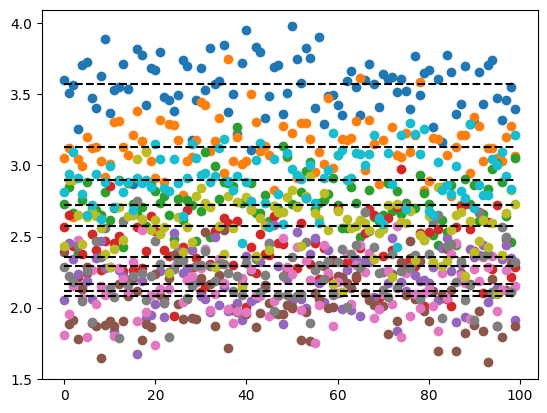

In [4]:
n=100
for theta in np.linspace(-1, 1, 10):
    plt.scatter(np.arange(0, n), generate_y(theta, n))
    plt.plot(np.arange(0, n), [avg_f(theta,n)]*n, 'k--')
plt.show()

In [54]:
k = 5
n=10000
thetas = np.random.uniform(-1, 1, k)
v_matrix = generate_vandermonde_matrix(thetas)
f_hats = np.zeros(k)
for i in range(k):
    f_hats[i] = avg_f(thetas[i], n)

parameters_hat = np.linalg.inv(v_matrix) @ f_hats
parameters_hat

array([ 2.08600559, -0.40569646,  1.50321542, -0.14537107, -0.16351341])

In [28]:
import numpy as np
from scipy.optimize import minimize_scalar

# Define the polynomial function f(x)
def f(parameters_hat, x):
    k = len(parameters_hat)

    result = parameters_hat[0]
    for i in range(1, k):
        result += parameters_hat[i]* x**i

    return result

# Define the objective function g(x)
def objective_function(x, parameters_hat):
    return f(parameters_hat, x)**2 + x**2 - 2 * x * f(parameters_hat, x)

# Define a separate objective function without the lambda function
def scalar_objective_function(x):
    return objective_function(x, parameters_hat)

# Set the bounds for x
bounds = (-1, 1)

# Minimize the objective function with bounds using minimize_scalar
result = minimize_scalar(scalar_objective_function, bounds=bounds, method='bounded')

# The optimal value of x
optimal_x = result.x

print("Optimal x:", optimal_x)
print("Minimum value of g(x):", result.fun)


Optimal x: 0.5280901040021548
Minimum value of g(x): 2.9336266189346096
